In [4]:
# ====== Packages =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from tqdm import tqdm

# ---- data manipulators ----
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

# ---- algorithms ----
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# ---- evaluation ------
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, RocCurveDisplay




# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh

# This line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

In [5]:
dataset = pd.read_pickle('pre_proccessed_data.pkl')
dataset

,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,gender,corona_result
0,18,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,female,0
1,18,cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,female,0
2,18,no cough,fever,no sore_throat,no shortness_of_breath,no head_ache,Other,male,0
3,18,cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,female,0
4,18,cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,male,0
...,...,...,...,...,...,...,...,...,...
278842,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,male,0
278843,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,female,0
278844,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,male,0
278845,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Contact with confirmed,female,1


# MODEL

## The first algo we'll use is RandodmForest (because all features are categorial) so the encoding will be as follow: (label1, label2, label3,.....) -> (0,1,2, .....).
## This way we dont had more features (like in using one hot encoding) and also tree based algorithems are not sensetive to the magnitude of the labels.
## Trees are good for imbalnced datasets

### Encoding:

In [6]:
encode_dict = {
                'cough': {'cough': 1, 'no cough': 0},
                'fever': {'fever': 1, 'no fever': 0},
                'sore_throat': {'sore_throat': 1, 'no sore_throat': 0},
                'shortness_of_breath': {'shortness_of_breath': 1, 'no shortness_of_breath': 0},
                'head_ache': {'head_ache': 1, 'no head_ache': 0},
                'test_indication': {'Abroad': 2, 'Contact with confirmed': 1, 'Other': 0},
                'gender': {'male': 1, 'female': 0}
              }

data_for_tree = dataset.replace(encode_dict)
data_for_tree
#hel.check_values_count(data_for_tree)

,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,gender,corona_result
0,18,0,0,0,0,0,0,0,0
1,18,1,0,0,0,0,0,0,0
2,18,0,1,0,0,0,0,1,0
3,18,1,0,0,0,0,0,0,0
4,18,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
278842,11,0,0,0,0,0,0,1,0
278843,11,0,0,0,0,0,0,0,0
278844,11,0,0,0,0,0,0,1,0
278845,11,0,0,0,0,0,1,0,1


### Split the data to train and test (we will use cross validation instead of having a validation set because of the small number of 'positive number')
### Because the data is imbalanced we'll use stratified random sampling so each set will represeent the whole data.

In [7]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8)
X = data_for_tree.drop('corona_result', axis=1)
y = data_for_tree['corona_result']
train_index, test_index = next(spliter.split(X, y))
X_train_raw, X_test = X.iloc[train_index], X.iloc[test_index]
y_train_raw, y_test = y.iloc[train_index], y.iloc[test_index]

### Due to imblanced model we'll oversample the minority class:
* Its important to oversample after spliting to train and test so same samples won't be in each set and cause to overfitting.

In [8]:
# Concatenate our training data back together
X = pd.concat([X_train_raw, y_train_raw], axis=1)

# Separate minority and majority classes
negative_samples = X[X['corona_result']==0]
positive_samples = X[X['corona_result']==1]

# Upsample the minotiry class
ratio = 1.0
upsampled_positive_samples = resample(positive_samples, replace=True, n_samples=int(len(negative_samples)*ratio), random_state=27)

# Combine majority and upsampled minority
X = pd.concat([negative_samples, upsampled_positive_samples])
X['corona_result'].value_counts()

# Split to X and y
X_train = X.drop('corona_result', axis=1)
y_train = X['corona_result']


In [9]:
y_train_raw.value_counts()

0    208006
1     11755
Name: corona_result, dtype: int64

In [7]:
## Trying SMOTE:
#from imblearn.over_sampling import SMOTE

#sm = SMOTE(1.0, random_state=27)
#X_train, y_train = sm.fit_resample(X_train_raw, y_train_raw)






In [10]:
y_train.value_counts()

0    208006
1    208006
Name: corona_result, dtype: int64

accuracy_score: 0.9465062521614095
 f1_score: 0.0
 recall_score: 0.0



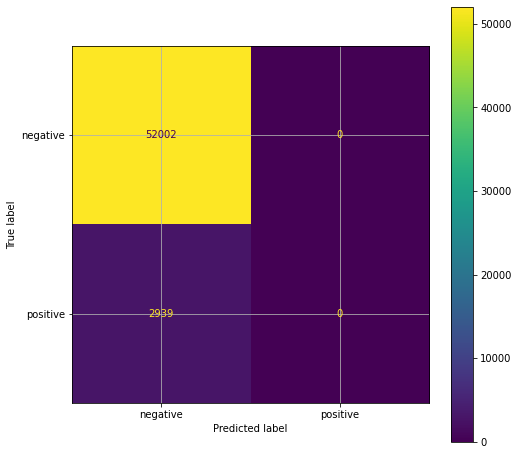

In [11]:
## Dunmmy classifier: for getting a simple baseline to compare with other classifiers
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
y_pred = dummy_classifier.predict(X_test)
mh.model_evaluation(y_test, y_pred)

accuracy_score: 0.9277406672612439
 f1_score: 0.5426267281105991
 recall_score: 0.8012929567880231

0.41020728096150494


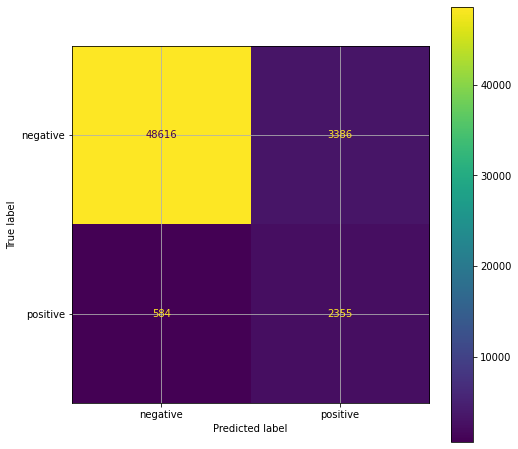

In [12]:
# train model
rfc = RandomForestClassifier(n_estimators=10, class_weight={0: 1, 1: 1})
rfc.fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

mh.model_evaluation(y_test, rfc_pred)
print(precision_score(y_test, rfc_pred))



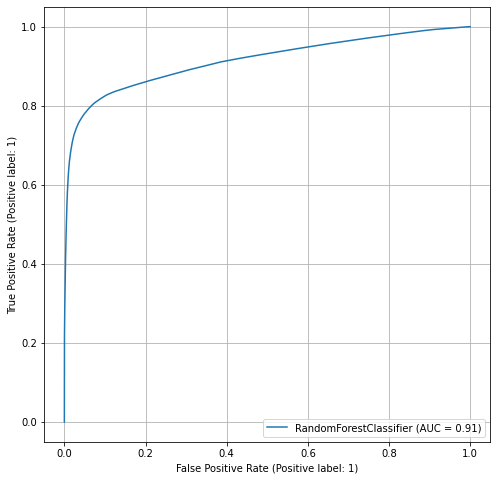

In [13]:

RocCurveDisplay.from_estimator(rfc, X_train, y_train)

# try to understand how to choose the right treshold. there is a method called roc_curve that return an array of thresholds and the thresholds are usable with predict_proba

# Note: the most immportant thing is to reduce the False Negative becaue we dont want people with corona on the streets -> the more important metric is recall

### Evaluation: